In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import transformers
print(transformers.__version__)

4.52.3


In [ ]:
pip show transformers

Name: transformers
Version: 4.52.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    classification_report, confusion_matrix
)
from underthesea import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv("df_train_clean.csv")
df_dev   = pd.read_csv("df_dev_clean.csv")
df_test  = pd.read_csv("df_test_clean.csv")

In [ ]:
for df in (df_train, df_dev, df_test):
    df['content_clean'] = df['content_clean'].fillna('').astype(str)
    assert 'label' in df.columns

##Without VnEmoLex

In [ ]:
classes = sorted(df_train['label'].unique())

In [ ]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(classes),
    y=df_train["label"].to_numpy()
)
class_weights = torch.tensor(weights, dtype=torch.float)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        lbl = self.labels[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids      = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        return {
            "input_ids":      input_ids,
            "attention_mask": attention_mask,
            "labels":         torch.tensor(lbl, dtype=torch.long)
        }

In [ ]:

MODEL_NAME = "vinai/phobert-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)
model      = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(classes)
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_ds = SentimentDataset(
    texts     = df_train["content_clean"].tolist(),
    labels    = df_train["label"].tolist(),
    tokenizer = tokenizer,
    max_len   = 128
)
dev_ds   = SentimentDataset(
    texts     = df_dev["content_clean"].tolist(),
    labels    = df_dev["label"].tolist(),
    tokenizer = tokenizer,
    max_len   = 128
)
test_ds  = SentimentDataset(
    texts     = df_test["content_clean"].tolist(),
    labels    = df_test["label"].tolist(),
    tokenizer = tokenizer,
    max_len   = 128
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":        accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro":    recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro":        f1_score(labels, preds, average="macro"),
        "f1_micro":        f1_score(labels, preds, average="micro")
    }

In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Sử dụng CrossEntropyLoss với trọng số
        loss_fn = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fn(logits, labels)
        if return_outputs:
            return loss, outputs
        return loss

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir                  = "./phobert_no_lex",
    num_train_epochs            = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    learning_rate               = 2e-5,
    weight_decay                = 0.01,
    logging_steps               = 100,
    eval_steps                  = 500,
    save_steps                  = 500,
    save_total_limit            = 1,
    do_eval                     = True,
    report_to                   = "none"
)

In [ ]:
trainer = WeightedTrainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_ds,
    eval_dataset    = dev_ds,
    tokenizer       = tokenizer,
    compute_metrics = compute_metrics
)

<ipython-input-15-e63369c54d1f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [ ]:
trainer.train()

Step,Training Loss
100,0.849900
200,0.633500
300,0.703300
400,0.691000
500,0.632500
600,0.645400
700,0.512800
800,0.699700
900,0.653900
1000,0.528700


TrainOutput(global_step=7145, training_loss=0.3437145408673083, metrics={'train_runtime': 1723.2654, 'train_samples_per_second': 33.152, 'train_steps_per_second': 4.146, 'total_flos': 3757917388700160.0, 'train_loss': 0.3437145408673083, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_and_plot(split_name, ds, df, trainer, class_names):
    print(f"\n=== Evaluation on {split_name} ===")
    metrics = trainer.evaluate(eval_dataset=ds)
    print("Accuracy      :", metrics.get("eval_accuracy"))
    print("F1-Macro      :", metrics.get("eval_f1_macro"))

    preds = trainer.predict(ds).predictions.argmax(-1)

    print("\nClassification Report:")
    print(classification_report(
        df["label"], preds,
        target_names=class_names,
        zero_division=0, digits=4
    ))

    # Sử dụng các chỉ số nhãn đúng thứ tự
    cm = confusion_matrix(df["label"], preds, labels=range(len(class_names)))
    plt.figure(figsize=(5,5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=class_names, yticklabels=class_names
    )
    plt.title(f"PhoBERT Confusion ({split_name})")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()


In [ ]:
class_names = ["Negative", "Neutral", "Positive"]


=== Evaluation on Test ===


Accuracy      : 0.9339861023373341
F1-Macro      : 0.8298891289573919

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9408    0.9595    0.9501      1409
     Neutral     0.6744    0.5210    0.5878       167
    Positive     0.9487    0.9547    0.9517      1590

    accuracy                         0.9340      3166
   macro avg     0.8547    0.8117    0.8299      3166
weighted avg     0.9308    0.9340    0.9318      3166



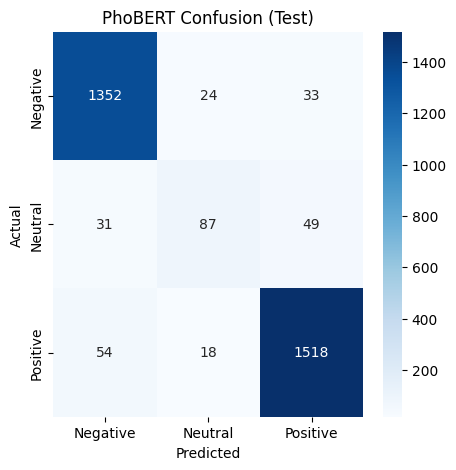

In [ ]:
evaluate_and_plot("Test",  test_ds,  df_test,  trainer, class_names)

##With VnEmoLex

In [ ]:
emo_df = pd.read_excel("/content/VnEmoLex.xlsx", sheet_name=0)
emo_df = emo_df.rename(columns={
    "Vietnamese":"word",
    "Positive":"pos_flag", "Negative":"neg_flag"
})

In [ ]:
words    = emo_df["word"].astype(str)
pos_flag = emo_df["pos_flag"].fillna(0).astype(int)
neg_flag = emo_df["neg_flag"].fillna(0).astype(int)

In [ ]:
lex_dict = {
    0: set(words[neg_flag==1]),
    1: set(words[(neg_flag==0)&(pos_flag==0)]),
    2: set(words[pos_flag==1])
}
classes = [0,1,2]
label_names = ["neg","neu","pos"]

In [ ]:
classes = sorted(df_train['label'].unique())

In [ ]:
weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(classes),
    y=df_train["label"].to_numpy()
)
class_weights = torch.tensor(weights, dtype=torch.float)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, lex_dict=None, max_len=128, lex_max_len=32):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer
        self.lex       = lex_dict or {}
        self.max_len   = max_len
        self.lex_max   = lex_max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        lbl = self.labels[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        input_ids     = enc["input_ids"].squeeze(0)
        attention_mask= enc["attention_mask"].squeeze(0)
        if self.lex:
            toks   = word_tokenize(txt.lower(), format="text").split()
            counts = [sum(1 for w in toks if w in self.lex[c]) for c in classes]
            lex_str= "[" + ",".join(map(str,counts)) + "]"
            lexc   = self.tokenizer(
                lex_str,
                truncation=True,
                padding="max_length",
                max_length=self.lex_max,
                return_tensors="pt"
            )
            lex_ids  = lexc["input_ids"].squeeze(0)[1:]
            lex_mask = lexc["attention_mask"].squeeze(0)[1:]
            new_ids  = torch.cat([input_ids, lex_ids], dim=0)[:self.max_len]
            new_mask = torch.cat([attention_mask, lex_mask], dim=0)[:self.max_len]
            input_ids, attention_mask = new_ids, new_mask

        return {
            "input_ids":      input_ids,
            "attention_mask": attention_mask,
            "labels":         torch.tensor(lbl, dtype=torch.long)
        }

In [ ]:
MODEL_NAME = "vinai/phobert-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)
model      = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(classes)
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_ds = SentimentDataset(
    df_train["content_clean"].tolist(),
    df_train["label"].tolist(),
    tokenizer, lex_dict
)
dev_ds   = SentimentDataset(
    df_dev["content_clean"].tolist(),
    df_dev["label"].tolist(),
    tokenizer, lex_dict
)
test_ds  = SentimentDataset(
    df_test["content_clean"].tolist(),
    df_test["label"].tolist(),
    tokenizer, lex_dict
)

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":        accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro":    recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro":        f1_score(labels, preds, average="macro"),
        "f1_micro":        f1_score(labels, preds, average="micro")
    }

In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fn(logits, labels)
        if return_outputs:
            return loss, outputs
        return loss

In [ ]:
training_args = TrainingArguments(
    output_dir                = "./phobert_lex_weighted",
    num_train_epochs          = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 16,
    learning_rate             = 2e-5,
    weight_decay              = 0.01,
    logging_steps             = 100,
    eval_steps                = 500,
    save_steps                = 500,
    save_total_limit          = 1,
    do_eval                   = True,
    report_to                 = "none"
)

In [ ]:
trainer = WeightedTrainer(
    model            = model,
    args             = training_args,
    train_dataset    = train_ds,
    eval_dataset     = dev_ds,
    tokenizer        = tokenizer,
    compute_metrics  = compute_metrics
)

<ipython-input-46-6b91ddf1a008>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [ ]:
trainer.train()

Step,Training Loss
100,0.846900
200,0.663700
300,0.608600
400,0.756300
500,0.628600
600,0.636200
700,0.531600
800,0.702600
900,0.576400
1000,0.524000


TrainOutput(global_step=7145, training_loss=0.3528131609116508, metrics={'train_runtime': 2362.8608, 'train_samples_per_second': 24.178, 'train_steps_per_second': 3.024, 'total_flos': 3757917388700160.0, 'train_loss': 0.3528131609116508, 'epoch': 5.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Khai báo label_names và classes ở ngoài hoặc ngay đầu notebook
# label_names = ["Negative", "Neutral", "Positive"]
# classes = [0, 1, 2]  # hoặc list(range(len(label_names)))

def evaluate_and_plot(split_name, ds, df):
    print(f"\n=== Evaluation on {split_name} ===")
    metrics = trainer.evaluate(eval_dataset=ds)
    print("Accuracy      :", metrics.get("eval_accuracy"))
    print("F1-Macro      :", metrics.get("eval_f1_macro"))

    preds = trainer.predict(ds).predictions.argmax(-1)

    print("\nClassification Report:")
    print(classification_report(
        df["label"], preds,
        target_names=label_names,
        zero_division=0, digits=4
    ))

    cm = confusion_matrix(df["label"], preds, labels=classes)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.title(f"PhoBERT+Lexicon Confusion ({split_name})")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()


In [ ]:
label_names = ["Negative", "Neutral", "Positive"]
classes = [0, 1, 2]


=== Evaluation on Test ===


Accuracy      : 0.9339861023373341
F1-Macro      : 0.8261635607126113

Classification Report:
              precision    recall  f1-score   support

    Negative     0.9429    0.9603    0.9515      1409
     Neutral     0.6860    0.4970    0.5764       167
    Positive     0.9447    0.9566    0.9506      1590

    accuracy                         0.9340      3166
   macro avg     0.8578    0.8046    0.8262      3166
weighted avg     0.9302    0.9340    0.9313      3166



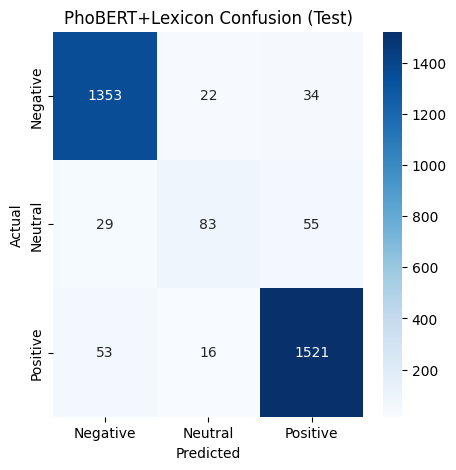

In [ ]:
evaluate_and_plot("Test",  test_ds,  df_test)